In [1]:
# File System
import os, sys, pickle as pkl
from os import path as pth
import itertools as it

# Plotting
from matplotlib import pyplot as plt
from matplotlib import ticker as mticker
from corner import corner

# Math
import numpy as np
from numpy import linalg as la
import pandas as pd
pd.options.mode.chained_assignment = None

from scipy.stats import norm, uniform, multivariate_normal
import scipy.optimize as opt
from functools import reduce, partial

# Display
from IPython.display import clear_output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from Model import TwoSignal, Signal
from mcmc import MHMCMC

data_path = "data"

In [2]:
np.random.seed(123)

In [3]:
class LnMinMCMC(MHMCMC):
    def selection(self):
        qs = self.proposal()
        r = uniform.rvs(0,1)
                   
        if (self.f(self.x) - self.f(np.array(qs)) > np.log(r)):
            self.x = qs

        return self.x 

In [4]:
def conf(s, interval=0.95):
    sord = np.sort(s)
    lo, hi = np.floor(s.size*(1-interval)/2), s.size - np.ceil(s.size*(1-interval)/2)
    return np.array([sord[int(lo)], sord[int(hi)]])

### Problem 1

In [5]:
with open(pth.join(data_path, 'dataset11.pkl'), 'rb') as f:
    d11 = pkl.load(f)

In [6]:
sig2 = TwoSignal(100, 257.5, np.zeros(5), d11)
sig2.set_params(sig2.analytic_params()[0])
_=opt.minimize(lambda p: TwoSignal.with_period_param(100, p, d11).negloglike()
             , np.array([sig2.T2, *sig2.params]))

In [7]:
amps = sig2.amplitude
amp_errs = sig2.analytic_amplitude_error

In [8]:
def param_prior(p):
    T = period_prior(p[0])
    dc = dc_prior(p[1])
    amp1 = amp1_prior(p[2:4])
    amp2 = amp2_prior(p[4:6])
    
    return -np.sum(np.log([T, dc, amp1, amp2]))

period_prior = lambda p: norm(sig2.T2, 0.21).pdf(p)
dc_prior = lambda p: norm(sig2.DC ,0.5).pdf(p)
amp1_prior = lambda p: norm(loc = amps[0], scale=2*amp_errs[0]).pdf(np.sqrt(np.sum(np.power(p, 2))))
amp2_prior = lambda p: norm(loc = amps[1], scale=2*amp_errs[1]).pdf(np.sqrt(np.sum(np.power(p, 2))))

In [9]:
prbm1_q = lambda p: norm.rvs(loc=p, scale=np.array([1e-3, 1e-1, 1e-2, 1e-2, 1e-3, 1e-2]))
prbm1_f = lambda p: param_prior(p) + TwoSignal.with_period_param(100, p, data=d11).negloglike()

params = sig2.params.copy()
# params[-2] = 0
params = np.array([sig2.T2, *params])

MC = LnMinMCMC(prbm1_f, prbm1_q, init_x=params)

In [10]:
K = 50_000

samples = MC.sample(K)
sample_array = np.array(samples)

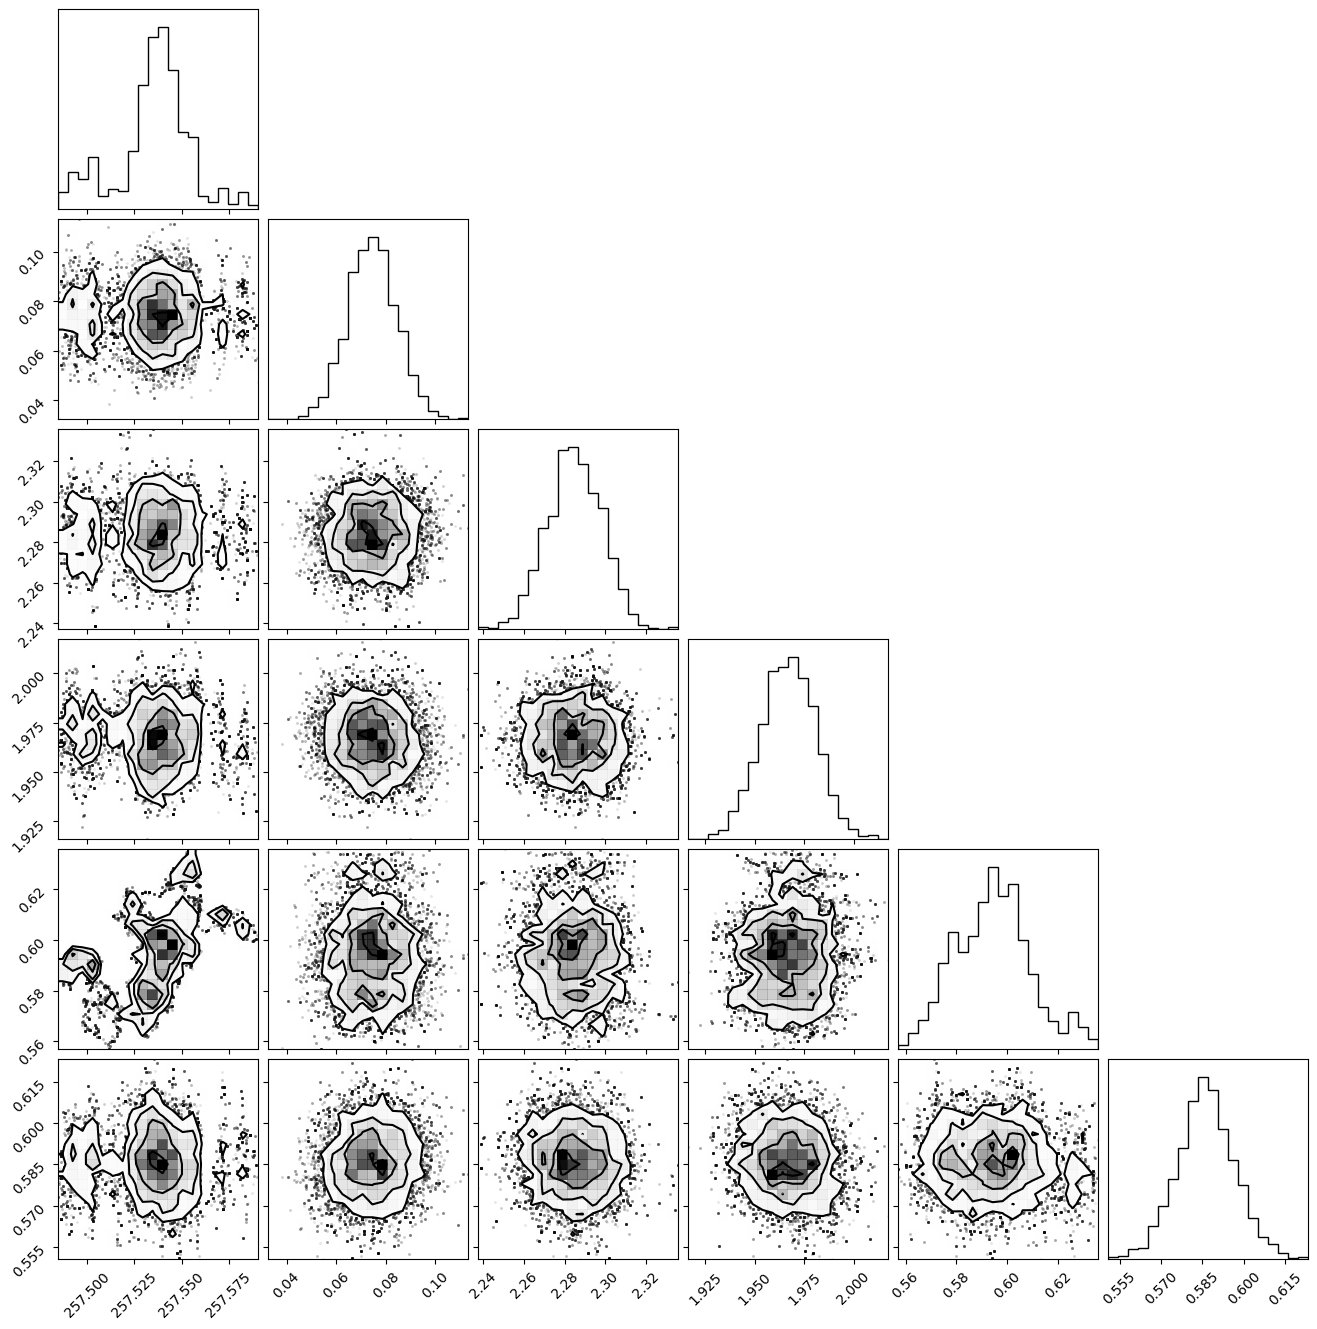

In [11]:
_ = corner(samples)

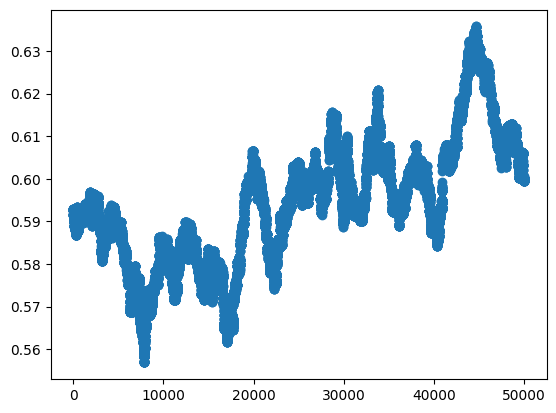

In [12]:
_ = plt.scatter(range(sample_array.shape[0]), sample_array[:,4])

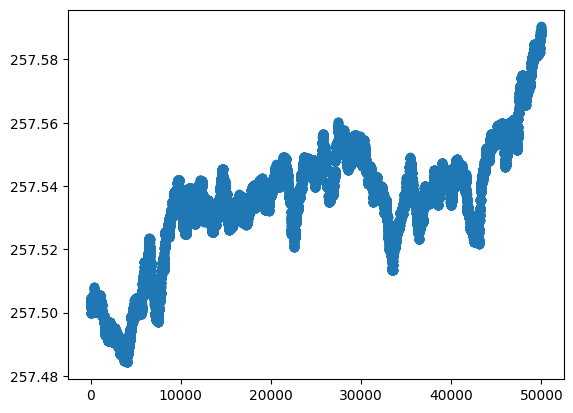

In [13]:
_ = plt.scatter(range(sample_array.shape[0]), sample_array[:,0])

In [14]:
sig = TwoSignal.with_period_param(100, np.mean(sample_array, axis=0), d11)

In [15]:
np.mean(samples, axis=0)
np.std(samples, axis=0)

array([2.57534933e+02, 7.43866229e-02, 2.28455312e+00, 1.96674036e+00,
       5.94370502e-01, 5.86171079e-01])

array([0.01949296, 0.00985524, 0.01336566, 0.01369108, 0.0147385 ,
       0.01047985])

In [16]:
ix = 4
conf(samples[:, ix]).reshape([2,1]) - np.mean(samples[:, ix])

array([[-0.02730586],
       [ 0.03283232]])

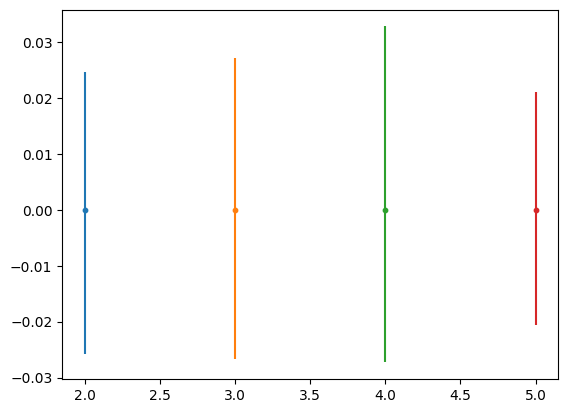

In [17]:
for ix in range(2, samples.shape[1]):
    s = samples[:,ix]
    _ = plt.errorbar(ix, 0, yerr=np.abs(conf(s).reshape([2,1])-np.mean(s)))
    _ = plt.scatter(ix, 0 ,s=10)

In [18]:
sig2.amplitude

(3.0162691873466714, 0.8288050755726364)

MCMC Average negloglike: 469.16288817012816 optimized negloglike: 469.33649346207613
Second Period: 257.53 ± 0.019 DC Level: 0.0744 ± 0.0099 Amplitude 1: 3.01 ± 0.013 Amplitude 2: 0.835 ± 0.013


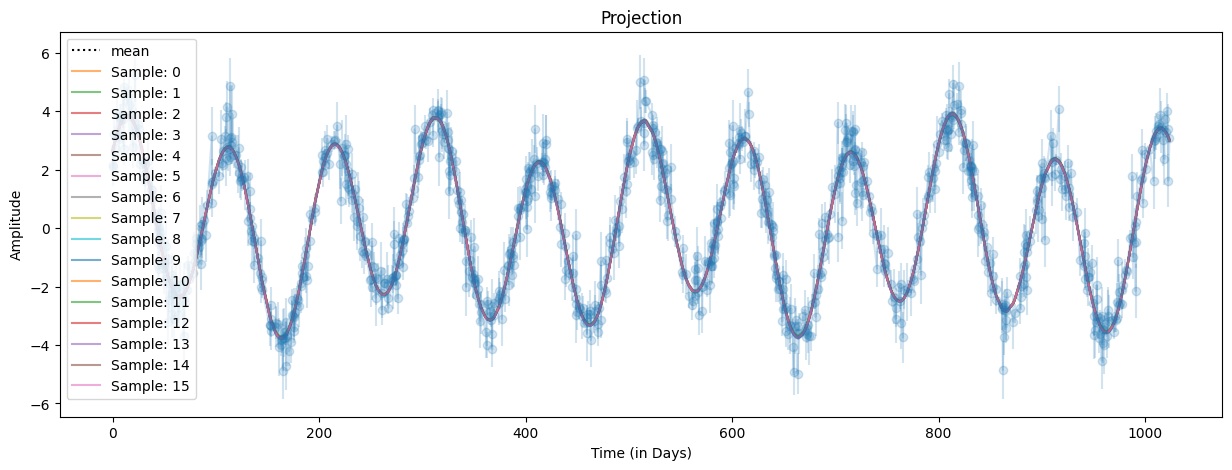

In [19]:
print(f"MCMC Average negloglike: {sig.negloglike()} optimized negloglike: {sig2.negloglike()}")

amp1_std = np.std(np.sqrt(np.sum(np.power(sample_array[:,2:4], 2), axis=1)))
amp2_std = np.std(np.sqrt(np.sum(np.power(sample_array[:,4:6], 2), axis=1)))

print(f"Second Period:{sig.T2: .5} \u00B1{np.std(samples[:,0]): .2}"
      ,f"DC Level:{sig.DC: .3} \u00B1{np.std(samples[:,1]): .2}"
      ,f"Amplitude 1:{sig.amplitude[0]: .3} \u00B1{amp1_std: .2}"
      ,f"Amplitude 2:{sig.amplitude[1]: .3} \u00B1{amp2_std: .2}")

fig, ax = plt.subplots(1,1, figsize=(15,5))
_ = ax.errorbar(d11.time, d11.data, yerr=d11.σy, marker="o", alpha=0.2)
_ = ax.plot(d11.time, sig.pred(d11.time), "k:", label="mean")

for ix, s in enumerate(np.random.choice(range(samples.shape[0]), size=16, replace=False)):
    _ = ax.plot(d11.time, TwoSignal(100, samples[s,0], np.array(samples[s,1:]), d11).pred(d11.time)
                , label=f"Sample: {ix}", alpha=0.6)

_ = ax.set_title("Projection")
_ = ax.set_xlabel("Time (in Days)")
_ = ax.set_ylabel("Amplitude")
_ = plt.legend()

### Problem 2

In [20]:
one_sig = Signal(100, [0.00569, 1, 1], d11)
one_sig.set_params(one_sig.analytic_params()[0])
_ = opt.minimize(one_sig.fit, one_sig.params)

In [21]:
prbm2_T2 = 257.47

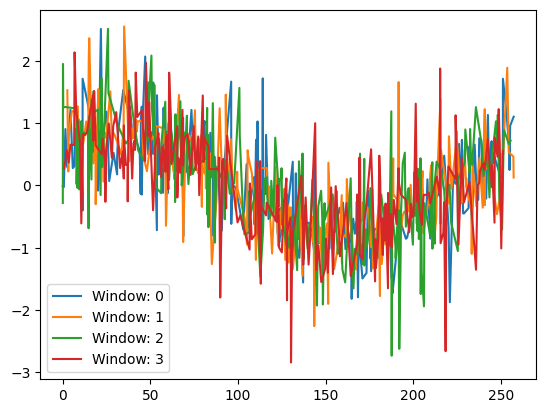

In [22]:
window = d11.time.apply(lambda x: x//prbm2_T2)
split_times = [d11.time.loc[window == i] for i in range(int(window.max())+1)]

for ix, ts in enumerate(split_times):  
    resid =  d11.loc[lambda x: x.time.isin(ts), 'data'] - one_sig.pred(ts)
    _ = plt.plot(ts-ix*prbm2_T2, resid, label=f"Window: {ix}")

_ = plt.legend()

From the above it seems like there is indeed a trend for the 257.47 day period. There seems to be a signal, remanisant of a cosine, at that time